In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv('metadata.csv')

In [3]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop column: 'Path'
    df = df.drop(columns=['Path'])
    # Drop column: 'Other_species30'
    df = df.drop(columns=['Other_species30'])
    # Drop column: 'Other_species28'
    df = df.drop(columns=['Other_species28'])
    # Drop column: 'Other_species29'
    df = df.drop(columns=['Other_species29'])
    # Drop column: 'Other_species27'
    df = df.drop(columns=['Other_species27'])
    # Drop column: 'Other_species26'
    df = df.drop(columns=['Other_species26'])
    # Drop column: 'Other_species25'
    df = df.drop(columns=['Other_species25'])
    # Drop column: 'Other_species24'
    df = df.drop(columns=['Other_species24'])
    # Drop column: 'Other_species23'
    df = df.drop(columns=['Other_species23'])
    # Drop column: 'Remarks'
    df = df.drop(columns=['Remarks'])
    # Drop column: 'Spectrogram_full'
    df = df.drop(columns=['Spectrogram_full'])
    # Drop column: 'Spectrogram_large'
    df = df.drop(columns=['Spectrogram_large'])
    # Drop column: 'Spectrogram_med'
    df = df.drop(columns=['Spectrogram_med'])
    # Drop column: 'Spectrogram_small'
    df = df.drop(columns=['Spectrogram_small'])
    # Drop column: 'file.name'
    df = df.drop(columns=['file.name'])
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Replace all instances of "?" with "" in column: 'Altitude'
    df['Altitude'] = df['Altitude'].replace(to_replace='?', value=np.nan)
    # Replace all instances of "" with "" in column: 'Time'
    df['Time'] = df['Time'].replace(to_replace='?', value=np.nan)
    # Ensure 'Altitude' and are numeric, coerce errors to NaN
    df['Altitude'] = pd.to_numeric(df['Altitude'], errors='coerce')
    # Drop rows with missing data in column: 'Date'
    df = df.dropna(subset=['Date','Altitude'])
    # Drop column: 'Url'
    df = df.drop(columns=['Url'])
    # Drop column: 'License'
    df = df.drop(columns=['License'])
    # Drop column: 'Audio_file'
    df = df.drop(columns=['Audio_file'])
    # Capitalize the first character in column: 'Locality'
    df['Locality'] = df['Locality'].str.title()
    return df

df_clean = clean_data(df.copy())
df = df_clean


In [4]:
# Convert Length from "minutes:seconds" format to total seconds
def convert_to_seconds(length):
    try:
        minutes, seconds = map(int, length.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return np.nan  # Handle invalid formats as NaN
    
df['Length_seconds'] = df['Length'].apply(convert_to_seconds)

df['Time'] = df['Time'].astype(str)

def convert_time_to_minutes(time_str):
    try:
        if ':' in time_str:
            hours, minutes = map(int, time_str.split(':'))
            return hours * 60 + minutes
        else:
            return np.nan  # Return NaN if the format is not as expected
    except (ValueError, AttributeError):
        return np.nan

df['Time_minutes'] = df['Time'].apply(convert_time_to_minutes)

In [9]:
# Preparing data for quality prediction

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


features = ['Length_seconds', 'Altitude', 'Time_minutes', 'Quality']
df_clean = df[features].dropna()

# Encode 'Quality' as numeric
label_encoder = LabelEncoder()
df_clean['Quality_encoded'] = label_encoder.fit_transform(df_clean['Quality'])

# Anomaly detection
anomaly_features = ['Length_seconds', 'Altitude', 'Time_minutes']
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_clean['Anomaly_Score'] = iso_forest.fit_predict(df_clean[anomaly_features])

# Keep only normal data (Anomaly_Score == 1)
df_clean = df_clean[df_clean['Anomaly_Score'] == 1].drop(columns=['Anomaly_Score'])


scaler = StandardScaler()
df_clean[['Length_seconds', 'Altitude', 'Time_minutes']] = scaler.fit_transform(
    df_clean[['Length_seconds', 'Altitude', 'Time_minutes']]
)


X = df_clean[['Length_seconds', 'Altitude', 'Time_minutes']]
y = df_clean['Quality_encoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train = X_train_smote
y_train = y_train_smote

d:\Praca\Projekty\Machine Learning\Birdcall Identification\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
d:\Praca\Projekty\Machine Learning\Birdcall Identification\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


d:\Praca\Projekty\Machine Learning\Birdcall Identification\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           A       0.52      0.48      0.50       165
           B       0.56      0.54      0.55       184
    no score       0.04      0.33      0.08         3

    accuracy                           0.51       352
   macro avg       0.37      0.45      0.37       352
weighted avg       0.54      0.51      0.52       352



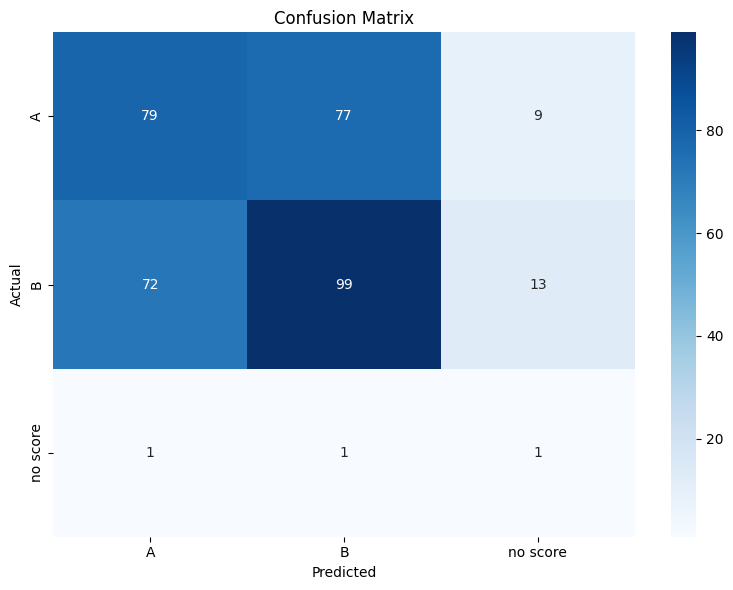

C:\Users\Grzegorz\AppData\Local\Temp\ipykernel_30796\903132904.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_model.feature_importances_, y=X.columns, palette='viridis')


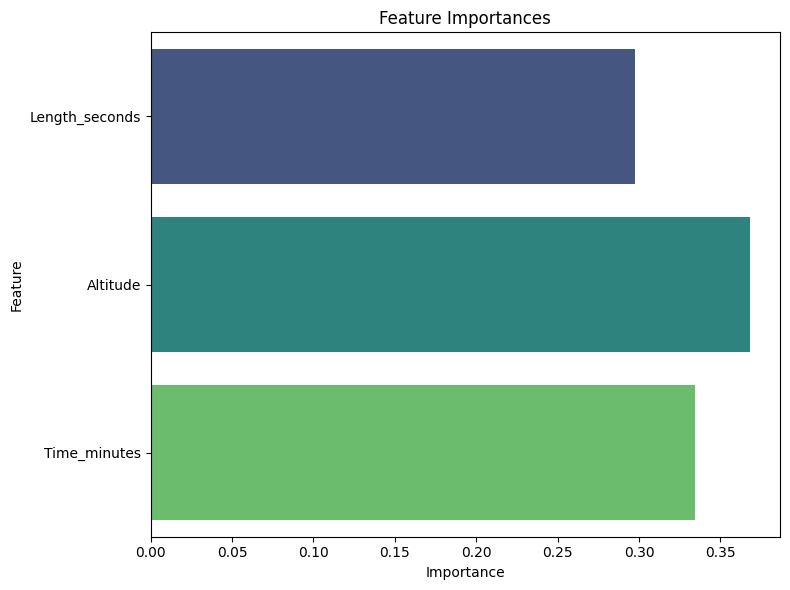

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Predicting the quality of a bird call

# Class weights for XGBoost
class_weights = y_train.value_counts(normalize=True)
class_weights = {i: 1 / class_weights[i] for i in range(len(class_weights))}


# Train an XGBoost classifier
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    scale_pos_weight=class_weights,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    max_depth=8,
    learning_rate = 0.05,
    n_estimators=200,
    subsample=0.8
)

xgb_model.fit(X_train, y_train)


# Make predictions
y_pred = xgb_model.predict(X_test)

# Get unique labels from y_test
unique_labels = sorted(set(y_test))


print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[label_encoder.inverse_transform([label])[0] for label in unique_labels]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_encoder.inverse_transform([label])[0] for label in unique_labels], 
            yticklabels=[label_encoder.inverse_transform([label])[0] for label in unique_labels])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_model.feature_importances_, y=X.columns, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           A       0.56      0.49      0.52       165
           B       0.58      0.54      0.56       184
    no score       0.05      0.67      0.10         3

    accuracy                           0.52       352
   macro avg       0.40      0.57      0.39       352
weighted avg       0.57      0.52      0.54       352



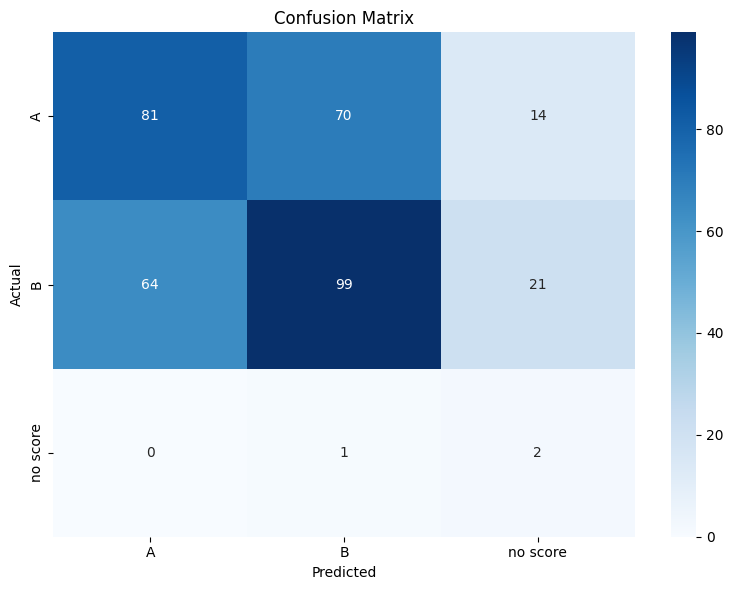

C:\Users\Grzegorz\AppData\Local\Temp\ipykernel_30796\1084110163.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_model.feature_importances_, y=X.columns, palette='viridis')


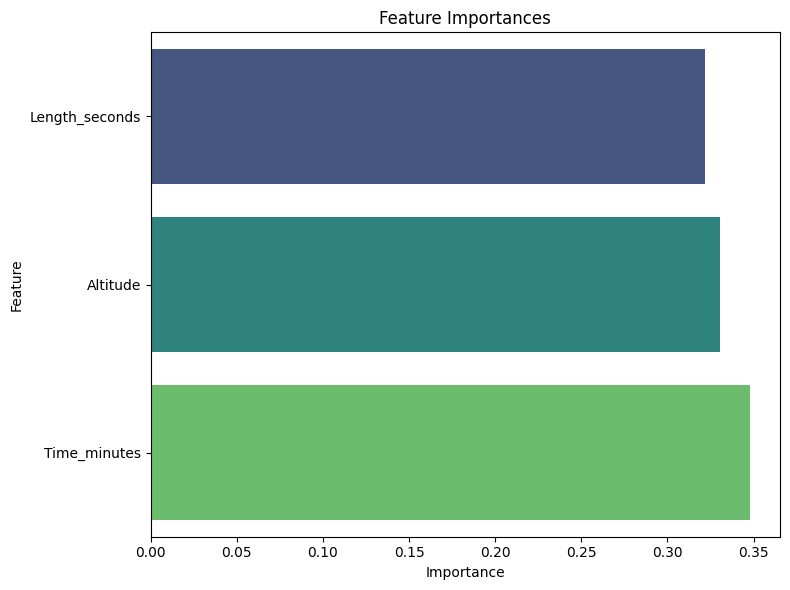

In [11]:
from sklearn.ensemble import RandomForestClassifier
# Random forest
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42
)


rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Get unique labels from y_test
unique_labels = sorted(set(y_test))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[label_encoder.inverse_transform([label])[0] for label in unique_labels]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_encoder.inverse_transform([label])[0] for label in unique_labels], 
            yticklabels=[label_encoder.inverse_transform([label])[0] for label in unique_labels])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=rf_model.feature_importances_, y=X.columns, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Classification Report:
              precision    recall  f1-score   support

           A       0.53      0.49      0.51       165
           B       0.56      0.55      0.56       184
    no score       0.11      0.67      0.19         3

    accuracy                           0.53       352
   macro avg       0.40      0.57      0.42       352
weighted avg       0.54      0.53      0.53       352



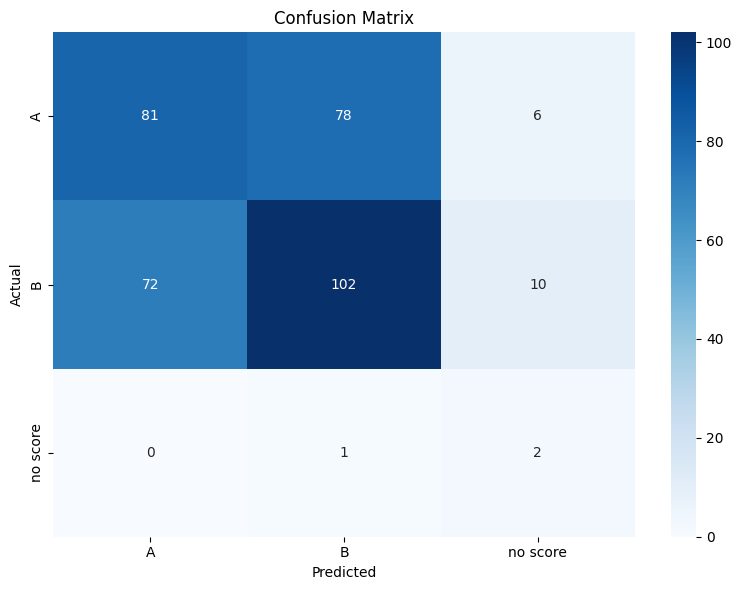

C:\Users\Grzegorz\AppData\Local\Temp\ipykernel_30796\4148129026.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_model.feature_importances_, y=X.columns, palette='viridis')


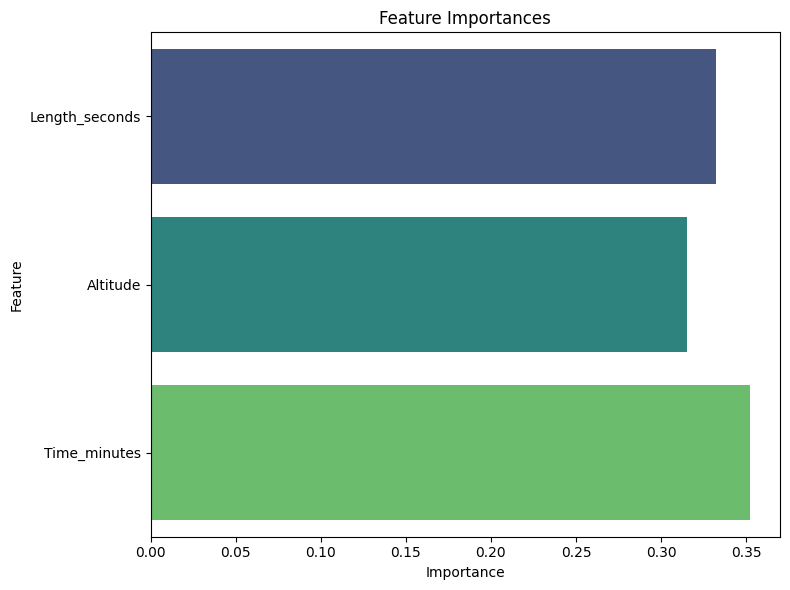

In [12]:
from sklearn.model_selection import GridSearchCV

# Random forest
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42
)

# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum tree depth
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at a leaf node
    'bootstrap': [True, False],           # Use bootstrap sampling
    'class_weight': ['balanced', 'balanced_subsample']  # Handle class imbalance
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='precision_macro',  # Metric to optimize
    cv=3,                       # 3-fold cross-validation
    verbose=2,
    n_jobs=-1                   # Use all available cores
)
grid_search.fit(X_train_smote, y_train_smote)
rf_model = grid_search.best_estimator_

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Get unique labels from y_test
unique_labels = sorted(set(y_test))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[label_encoder.inverse_transform([label])[0] for label in unique_labels]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[label_encoder.inverse_transform([label])[0] for label in unique_labels], 
            yticklabels=[label_encoder.inverse_transform([label])[0] for label in unique_labels])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=rf_model.feature_importances_, y=X.columns, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()